In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the Data

In [ ]:
# Data Directories
dir = "dataset_19/"


# Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

notumor       120
glioma        120
meningioma    120
pituitary     120
dtype: int64

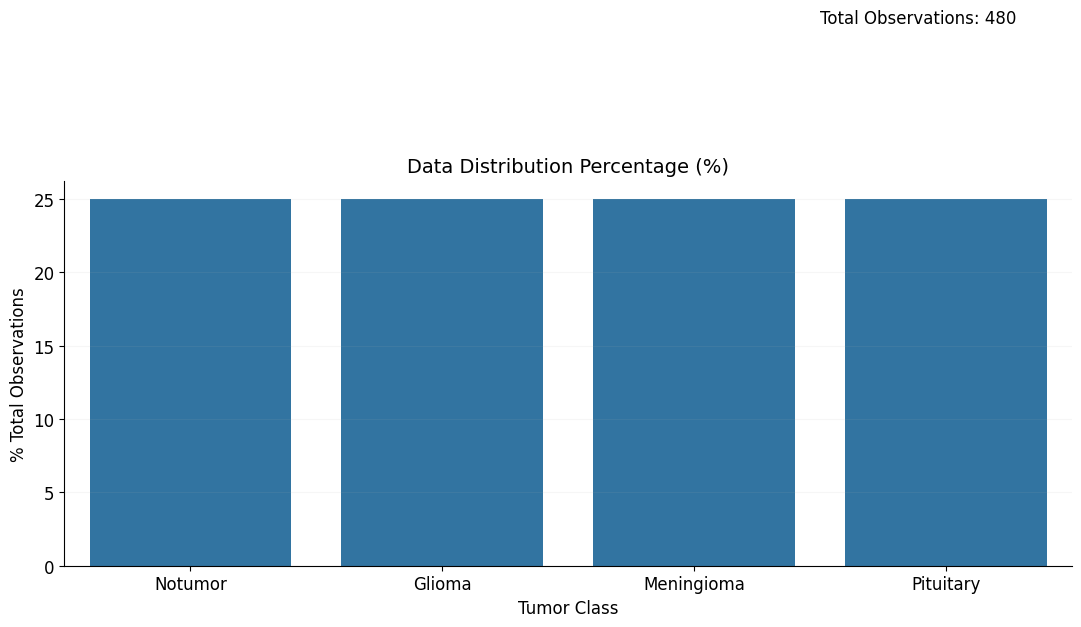

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

In [ ]:
# from tqdm import tqdm
# import cv2
# import imutils

# def crop_img(img):

#   # Find extreme points on the image and crop the rectangular out

#   gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#   gray = cv2.GaussianBlur(gray, (3, 3), 0)

#   # threshold the image, then perform a series of erosions +
#   # dilations to remove any small regions of noise
#   thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#   thresh = cv2.erode(thresh, None, iterations=2)
#   thresh = cv2.dilate(thresh, None, iterations=2)

#   # find contours in thresholded image, then grab the largest one
#   cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   cnts = imutils.grab_contours(cnts)
#   c = max(cnts, key=cv2.contourArea)

#   # find the extreme points
#   extLeft = tuple(c[c[:, :, 0].argmin()][0])
#   extRight = tuple(c[c[:, :, 0].argmax()][0])
#   extTop = tuple(c[c[:, :, 1].argmin()][0])
#   extBot = tuple(c[c[:, :, 1].argmax()][0])
#   ADD_PIXELS = 0
#   new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

#   return new_img

# def preprocess_images(directory):
#     for dir in os.listdir(directory):
#         path = os.path.join(directory, dir)
#         for img_name in os.listdir(path):
#             img_path = os.path.join(path, img_name)
#             img = cv2.imread(img_path)
#             cropped_img = crop_img(img)
#             processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
#             processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
#             processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
#             processed_img = cv2.resize(processed_img, (224, 224))
#             cv2.imwrite(img_path, processed_img)


# # Preprocess the images before generating data
# preprocess_images(dir)

# # Display 9 image using matplotlib
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for curr_index in os.listdir(dir):
#         path = os.path.join(dir, curr_index)
#         for img_name in os.listdir(path):
#             img_path = os.path.join(path, img_name)
#             image = plt.imread(img_path)
#             plt.imshow(image)
#             plt.title(curr_index)
#             break
#         break

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


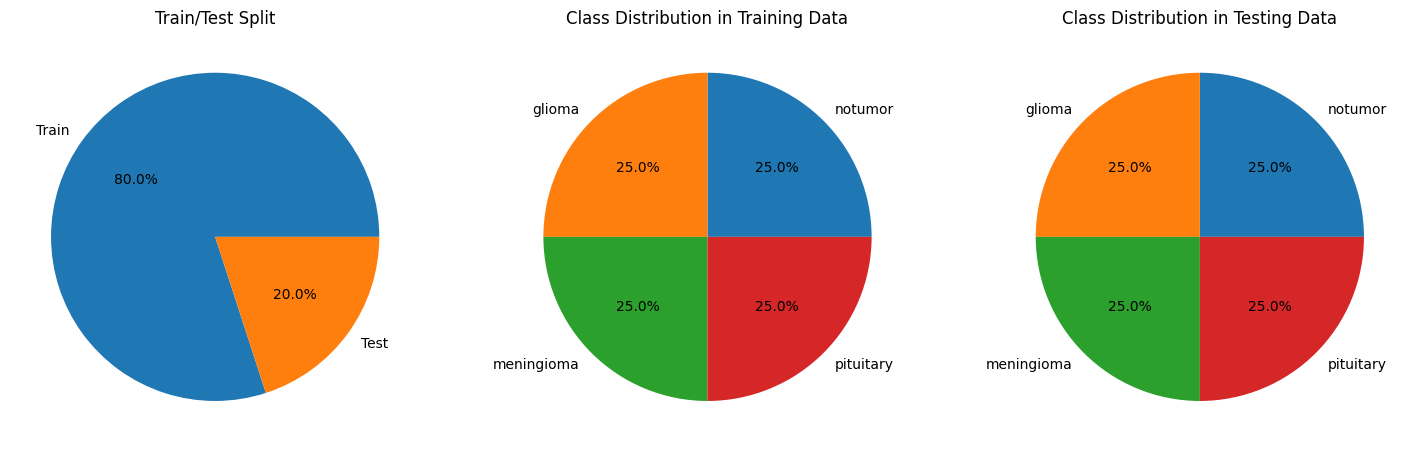

In [ ]:
classes = os.listdir(dir)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation',
    shuffle=False)


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# To Check Data Loading and Augmentation


In [ ]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Installing TensorFlow Addon and vit-keras Package

In [ ]:
! pip install tensorflow-addons vit-keras optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.0 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [ ]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, layers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import optuna

# Function to create ViT model
def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate):
    vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Allow finetuning of all layers
    for layer in vit_model.layers:
        layer.trainable = True

    inputs = Input(shape=input_shape, dtype=tf.float32)
    x = vit_model(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.02))(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# # Parameters
# input_shape = (224, 224, 3)
# num_classes = len(classes)  # Define the number of your classes
learning_rate = 0.0001  # Optimized learning rate
# dropout_rate = 0.3391265705752909  # From Optuna

def objective(trial):
    # Suggest values for the learning rate and dropout rate within a narrower range around your best-known values
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-4 * 0.8, 1e-4 * 1.2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.4)

    input_shape = (224, 224, 3)
    num_classes = len(classes)  # Define the number of your classes

    model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=8,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    model.load_weights(model_file)
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

[I 2024-06-14 07:38:55,084] A new study created in memory with name: no-name-1a312331-753d-47ca-9e45-c0ed477de88b
<ipython-input-12-383d5e3df18c>:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.4)


347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.5833
Epoch 1: val_loss improved from inf to 1.06178, saving model to vit_brain_mri.keras
24/24 [==============================] - 82s 1s/step - loss: 1.3394 - accuracy: 0.5833 - val_loss: 1.0618 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.8151
Epoch 2: val_loss improved from 1.06178 to 0.68395, saving model to vit_brain_mri.keras
24/24 [==============================] - 28s 1s/step - loss: 0.6599 - accuracy: 0.8151 - val_loss: 0.6840 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.9089
Epoch 3: val_loss did not improve from 0.68395
24/24 [==============================] - 17s 719ms/step - loss: 0.4042 - accuracy: 0.9089 - val_loss: 0.8095 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - loss: 0.34

[I 2024-06-14 07:48:41,718] Trial 0 finished with value: 0.6655248999595642 and parameters: {'dropout_rate': 0.3154517427823415}. Best is trial 0 with value: 0.6655248999595642.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.1720 - accuracy: 0.6016
Epoch 1: val_loss improved from inf to 1.17526, saving model to vit_brain_mri.keras
24/24 [==============================] - 72s 1s/step - loss: 1.1720 - accuracy: 0.6016 - val_loss: 1.1753 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.8385
Epoch 2: val_loss improved from 1.17526 to 0.53740, saving model to vit_brain_mri.keras
24/24 [==============================] - 26s 1s/step - loss: 0.6272 - accuracy: 0.8385 - val_loss: 0.5374 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.9115
Epoch 3: val_loss did not improve from 0.53740
24/24 [==============================] - 18s 735ms/step - loss: 0.4145 - accuracy: 0.9115 - val_loss: 0.8711 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - 

[I 2024-06-14 07:57:54,299] Trial 1 finished with value: 0.5207374691963196 and parameters: {'dropout_rate': 0.33360623793483474}. Best is trial 1 with value: 0.5207374691963196.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.3407 - accuracy: 0.5391
Epoch 1: val_loss improved from inf to 0.87332, saving model to vit_brain_mri.keras
24/24 [==============================] - 70s 1s/step - loss: 1.3407 - accuracy: 0.5391 - val_loss: 0.8733 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.8255
Epoch 2: val_loss did not improve from 0.87332
24/24 [==============================] - 18s 755ms/step - loss: 0.6898 - accuracy: 0.8255 - val_loss: 0.9700 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.8698
Epoch 3: val_loss improved from 0.87332 to 0.55237, saving model to vit_brain_mri.keras
24/24 [==============================] - 35s 1s/step - loss: 0.5088 - accuracy: 0.8698 - val_loss: 0.5524 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - 

[I 2024-06-14 08:07:14,077] Trial 2 finished with value: 0.5523682236671448 and parameters: {'dropout_rate': 0.3159772495722526}. Best is trial 1 with value: 0.5207374691963196.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.1765 - accuracy: 0.6224
Epoch 1: val_loss improved from inf to 1.17788, saving model to vit_brain_mri.keras
24/24 [==============================] - 85s 2s/step - loss: 1.1765 - accuracy: 0.6224 - val_loss: 1.1779 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.8359
Epoch 2: val_loss improved from 1.17788 to 0.62097, saving model to vit_brain_mri.keras
24/24 [==============================] - 30s 1s/step - loss: 0.6336 - accuracy: 0.8359 - val_loss: 0.6210 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.9141
Epoch 3: val_loss did not improve from 0.62097
24/24 [==============================] - 18s 757ms/step - loss: 0.4014 - accuracy: 0.9141 - val_loss: 0.6526 - val_accuracy: 0.8021 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - 

[I 2024-06-14 08:17:07,218] Trial 3 finished with value: 0.3424973487854004 and parameters: {'dropout_rate': 0.32755569499826637}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.94023, saving model to vit_brain_mri.keras
24/24 [==============================] - 90s 2s/step - loss: 1.3792 - accuracy: 0.5312 - val_loss: 0.9402 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.8177
Epoch 2: val_loss improved from 0.94023 to 0.50411, saving model to vit_brain_mri.keras
24/24 [==============================] - 41s 2s/step - loss: 0.6297 - accuracy: 0.8177 - val_loss: 0.5041 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.8984
Epoch 3: val_loss did not improve from 0.50411
24/24 [==============================] - 19s 769ms/step - loss: 0.4628 - accuracy: 0.8984 - val_loss: 0.8126 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - 

[I 2024-06-14 08:27:54,769] Trial 4 finished with value: 0.4133276045322418 and parameters: {'dropout_rate': 0.3961611826689738}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.6146
Epoch 1: val_loss improved from inf to 1.17376, saving model to vit_brain_mri.keras
24/24 [==============================] - 80s 2s/step - loss: 1.2089 - accuracy: 0.6146 - val_loss: 1.1738 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.8281
Epoch 2: val_loss improved from 1.17376 to 0.68388, saving model to vit_brain_mri.keras
24/24 [==============================] - 35s 1s/step - loss: 0.6144 - accuracy: 0.8281 - val_loss: 0.6839 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.9036
Epoch 3: val_loss improved from 0.68388 to 0.63829, saving model to vit_brain_mri.keras
24/24 [==============================] - 32s 1s/step - loss: 0.4162 - accuracy: 0.9036 - val_loss: 0.6383 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 4/8
24/24 [======

[I 2024-06-14 08:37:59,231] Trial 5 finished with value: 0.5436949133872986 and parameters: {'dropout_rate': 0.3458540859454179}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.3566 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 1.25219, saving model to vit_brain_mri.keras
24/24 [==============================] - 70s 1s/step - loss: 1.3566 - accuracy: 0.5312 - val_loss: 1.2522 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.7734
Epoch 2: val_loss improved from 1.25219 to 1.06493, saving model to vit_brain_mri.keras
24/24 [==============================] - 31s 1s/step - loss: 0.7674 - accuracy: 0.7734 - val_loss: 1.0649 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.8255
Epoch 3: val_loss improved from 1.06493 to 0.68708, saving model to vit_brain_mri.keras
24/24 [==============================] - 36s 2s/step - loss: 0.6095 - accuracy: 0.8255 - val_loss: 0.6871 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/8
24/24 [======

[I 2024-06-14 08:47:13,660] Trial 6 finished with value: 0.6166287660598755 and parameters: {'dropout_rate': 0.3639485023071929}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.3145 - accuracy: 0.5885
Epoch 1: val_loss improved from inf to 1.00707, saving model to vit_brain_mri.keras
24/24 [==============================] - 94s 2s/step - loss: 1.3145 - accuracy: 0.5885 - val_loss: 1.0071 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.7708
Epoch 2: val_loss did not improve from 1.00707
24/24 [==============================] - 17s 709ms/step - loss: 0.7505 - accuracy: 0.7708 - val_loss: 1.0698 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8958
Epoch 3: val_loss improved from 1.00707 to 0.64776, saving model to vit_brain_mri.keras
24/24 [==============================] - 28s 1s/step - loss: 0.4500 - accuracy: 0.8958 - val_loss: 0.6478 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s - 

[I 2024-06-14 08:57:46,840] Trial 7 finished with value: 0.4894675016403198 and parameters: {'dropout_rate': 0.3778822495563685}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.4862 - accuracy: 0.5156
Epoch 1: val_loss improved from inf to 1.45061, saving model to vit_brain_mri.keras
24/24 [==============================] - 95s 2s/step - loss: 1.4862 - accuracy: 0.5156 - val_loss: 1.4506 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.7943
Epoch 2: val_loss improved from 1.45061 to 1.37948, saving model to vit_brain_mri.keras
24/24 [==============================] - 40s 2s/step - loss: 0.7623 - accuracy: 0.7943 - val_loss: 1.3795 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.8594
Epoch 3: val_loss improved from 1.37948 to 0.74491, saving model to vit_brain_mri.keras
24/24 [==============================] - 64s 3s/step - loss: 0.5302 - accuracy: 0.8594 - val_loss: 0.7449 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 4/8
24/24 [======

[I 2024-06-14 09:08:52,368] Trial 8 finished with value: 0.6719956994056702 and parameters: {'dropout_rate': 0.3845029744398004}. Best is trial 3 with value: 0.3424973487854004.


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.3404 - accuracy: 0.6016
Epoch 1: val_loss improved from inf to 1.16852, saving model to vit_brain_mri.keras
24/24 [==============================] - 114s 3s/step - loss: 1.3404 - accuracy: 0.6016 - val_loss: 1.1685 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.8177
Epoch 2: val_loss improved from 1.16852 to 0.57926, saving model to vit_brain_mri.keras
24/24 [==============================] - 66s 3s/step - loss: 0.6608 - accuracy: 0.8177 - val_loss: 0.5793 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8958
Epoch 3: val_loss did not improve from 0.57926
24/24 [==============================] - 17s 703ms/step - loss: 0.4359 - accuracy: 0.8958 - val_loss: 0.5856 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - ETA: 0s -

[I 2024-06-14 09:19:42,181] Trial 9 finished with value: 0.563378632068634 and parameters: {'dropout_rate': 0.318557787996524}. Best is trial 3 with value: 0.3424973487854004.


Best trial:
  Value: 0.3424973487854004
  Params: 
    dropout_rate: 0.32755569499826637


In [ ]:
best_dropout_rate = trial.params['dropout_rate']

# Create and compile the model with the best hyperparameters
model = create_vit_model((224, 224, 3), len(classes), learning_rate, best_dropout_rate)

checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

# Save the model
model.save(model_file)

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add a legend to specify which line is which
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

**Model Visualisation (Evaluation)**

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 16
input_shape = (224, 224, 3)
num_classes = 4
# learning_rate = best_learning_rate
# dropout_rate = best_dropout_rate
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20
)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Define the ViT Model
    model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.3, min_lr=1e-6, verbose=1)
    # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=8,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

In [ ]:

import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()